In [285]:
%%capture
!pip install sentinelhub --upgrade
!pip install geopandas --upgrade

### Config

In [75]:
%matplotlib inline
from sentinelhub import SHConfig
config = SHConfig()
#config

In [76]:
config.sh_client_id = ""
config.sh_client_secret = ""
config.save()

In [100]:
import datetime
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, Polygon, MultiPolygon, MultiLineString

from shapely import wkt

import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SentinelHubCatalog,
    filter_times,
    BBoxSplitter, OsmSplitter, TileSplitter, CustomGridSplitter, UtmZoneSplitter, UtmGridSplitter,
    to_utm_bbox,
    read_data
)
from sentinelhub import WebFeatureService
gpd.__version__

'0.9.0'

In [101]:
INSTANCE_ID = ''

config = SHConfig()
if INSTANCE_ID:
    config.instance_id = INSTANCE_ID

### calc Russia regions bbox tiles

In [152]:
name='Иркутская область'
resolution = 10
tsizeY=2240*10
tsizeX=2240*10
date_start='01-07-2021'
date_end='21-07-2021'
russia=gpd.read_file('../data/ATD_subject.shp',encoding='cp1251')
reg=russia.loc[russia['SubjectNam']=='%s'%name]

In [153]:
def get_tiles_one_region(reg_data, name,tsizeY,tsizeX):
    try:
        #get bbox in utm and calc dimensions
        reg=reg_data.loc[reg_data['SubjectNam']=='%s'%name].bounds
        coords_wgs84 = [reg.minx, reg.miny, reg.maxx, reg.maxy]
        BBOX = BBox(bbox=coords_wgs84, crs=CRS.WGS84)
        BBOX=to_utm_bbox(BBOX)
        dsizex=round((BBOX.upper_right[0]-BBOX.lower_left[0])/tsizeX)
        dsizey=round((BBOX.upper_right[1]-BBOX.lower_left[1])/tsizeY)
        #get aoi to wkt
        reg=russia.loc[russia['SubjectNam']=='%s'%name]
        wkt_array = reg['geometry'].to_wkt()
        wkt_reg=wkt.loads(wkt_array.values[0])
        #use bbox splitter
        bbox_splitter = BBoxSplitter([wkt_reg],CRS.WGS84, (int(dsizex), int(dsizey)))
        bbox_list = bbox_splitter.get_bbox_list()
        gs=[t.geometry for t in bbox_list]
        tiles_pd=gpd.GeoDataFrame(gs,geometry=gs,crs='EPSG:4326')
        tiles_pd=tiles_pd.drop(0,axis=1)
        #overlay with aoi
        res=gpd.overlay(tiles_pd,reg,how='intersection')
        res['id']=res.index
        return bbox_list,res
    except IOError as e:
        print(str(e))   

In [154]:
rus_tiles=pd.DataFrame(columns=['SubjectNam','geometry'])
rus_bbox=[]
for reg_name in russia['SubjectNam'].unique():
        bboxtiles,restmp=get_tiles_one_region(russia, reg_name,tsizeY=tsizeY,tsizeX=tsizeY)
        #print(len(bboxtiles))
        rus_tiles=rus_tiles.append(restmp,ignore_index=True)
        rus_bbox.append(bboxtiles)

In [155]:
rus_bbox=[item for sublist in rus_bbox for item in sublist]

In [156]:
rus_tiles.shape,len(rus_bbox)

((36460, 4), 36460)

In [157]:
rus_tiles['id']=rus_tiles.index
rus_tiles_gpd=gpd.GeoDataFrame(rus_tiles,geometry=rus_tiles['geometry'],crs='EPSG:4326')
rus_tiles_gpd.to_file('tiles/russia_tiles.shp',encoding='utf-8')

In [168]:
evalscript_3bandsS2 = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B03","B08","B11","CLM"],
                units: "DN"
            }],
            output: {
                bands: 4,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B03,
                sample.B08,
                sample.B11,
                sample.CLM];
    }
"""

In [159]:
def wfs_request(bbox,date_start, date_end):
    wfs_iterator= WebFeatureService(
        bbox,
        time_interval=(date_start, date_end),
        data_collection=DataCollection.SENTINEL2_L1C,
        config=config
    )
    results = list(wfs_iterator)
    if len (results) > 0:
        resdf=pd.DataFrame(columns=['date','cloud','id'])
        for res in results:
            tmp=dict()
            tmp['date']=res['properties']['date']
            tmp['cloud']=res['properties']['cloudCoverPercentage']
            tmp['id']=res['properties']['id']
            resdf=resdf.append(tmp,ignore_index=True)
            resdf=resdf.sort_values(by=['date','cloud'],ascending=[False,True])
        return resdf.head(1)
    else:
        return 0

In [160]:
tmp=wfs_request(rus_bbox[1000],date_start, date_end)
date=tmp['date'].values[0]

In [161]:
date

'2021-07-19'

In [183]:
def request_bands(evalscript,config,data_folder,bbox,size,date_start, date_end):
    try:
        req= SentinelHubRequest(
            data_folder=data_folder,
            evalscript=evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(date_start, date_end),
                    mosaicking_order='leastCC'
            )],
            responses=[
                SentinelHubRequest.output_response('default', MimeType.TIFF)
            ],
            bbox=bbox,
            size=size,
            config=config
        )
        img = req.get_data(save_data=True,)
        return img
    except IOError as e:
        print(str(e))

In [192]:
def get_tiles_data(evalscript,config,data_folder,tiles,bbox_list,date_start, date_end,size):
    try:
        for n,tile in tiles.iterrows():
            bbox=bbox_list[tile['id']]
            resdf=wfs_request(bbox,date_start, date_end)
            #check if no data
            if resdf.empty:
                print('No data')
                continue
            else:
                #get latest img with lowest cloud coverage
                date=resdf['date'].values[0]
                #size = bbox_to_dimensions(bbox, resolution=10)
                try:
                    img=request_bands(evalscript,config,data_folder,bbox,size,date, date_end)
                    print(img[0].shape)
                    plt.imshow(img[0][:,:,1])  
                except IOError as e:
                    print('tile error ID:%s'%tile['id'])
                    continue
    except IOError as e:
        print(str(e))

In [193]:
tiles=rus_tiles.sample(5)
data_folder='fires/img'

In [194]:
tiles

,SubjectNam,geometry,q,id
13611,Липецкая область,"POLYGON ((40.42666 51.94987, 40.42666 52.09905...",NaN,13611
26381,Республика Саха (Якутия),"POLYGON ((145.95836 71.54332, 145.95836 71.750...",1.0,26381
35133,Ямало-Ненецкий автономный округ,"POLYGON ((68.93504 72.53091, 68.93575 72.53091...",NaN,35133
34130,Ханты-Мансийский автономный округ - Югра,"POLYGON ((74.50258 62.90577, 74.50258 63.04583...",1.0,34130
16510,Омская область,"POLYGON ((73.50742 57.75397, 73.50742 57.95954...",NaN,16510


In [187]:
bbox=rus_bbox[35824]
size = bbox_to_dimensions(bbox, resolution=10)
size

(2317, 2387)

(2240, 2240, 4)
(2240, 2240, 4)
(2240, 2240, 4)
(2240, 2240, 4)
(2240, 2240, 4)
Wall time: 1min 38s


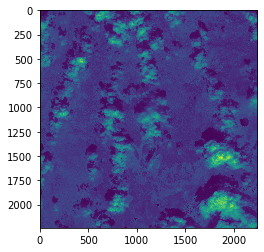

In [195]:
%%time
get_tiles_data(evalscript_3bandsS2,config,data_folder,tiles,rus_bbox,date_start, date_end,size=(2240,2240))